In [1]:
from __future__ import print_function
import torch

## Play with tensors  

In [2]:
tensor = -1*torch.rand(4, 5)
tensor2 = -1*torch.rand(2, 10)

In [3]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype toget

In [4]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [5]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [6]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [7]:
out.backward()

In [8]:
(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

## Define basic neural network  

In [9]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

In [10]:
class Net(nn.Module):
    def __init__(self): 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

    def num_flat_features(self, x): 
        size = x.size()[1:]
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features

In [11]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [13]:
inp = torch.randn(1, 1, 32, 32)
out = net(inp)
print(out)

tensor([[-0.0817, -0.1592,  0.0770,  0.0678,  0.0877,  0.0149,  0.0029, -0.0853,
         -0.0825,  0.0267]], grad_fn=<AddmmBackward>)


In [14]:
net.zero_grad()
out.backward(torch.randn(1, 10))

net.zero_grad()
out.backward(torch.randn(1, 10))

### Note 

torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, nn.Conv2d will take in a 4D Tensor of ```nSamples x nChannels x Height x Width```.

If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [15]:
output = net(inp)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8080, grad_fn=<MseLossBackward>)


In [16]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [17]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0102,  0.0163, -0.0263, -0.0100,  0.0128, -0.0061])


In [18]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [19]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(inp)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## Training an image classifier
We will do the following steps in order:

Load and normalizing the CIFAR10 training and test datasets using torchvision
Define a Convolutional Neural Network
Define a loss function
Train the network on the training data
Test the network on the test data

### 1. Loading and normalizing CIFAR10
Using torchvision, it’s extremely easy to load CIFAR10.



In [20]:
import torch 
import torchvision 
import torchvision.transforms as transforms 

In [21]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [22]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


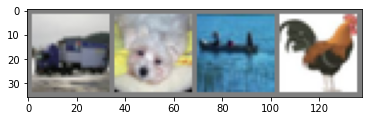

truck   dog  ship  bird


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.886
[1,  6000] loss: 1.703
[1,  8000] loss: 1.608
[1, 10000] loss: 1.551
[1, 12000] loss: 1.511
[2,  2000] loss: 1.429
[2,  4000] loss: 1.421
[2,  6000] loss: 1.387
[2,  8000] loss: 1.360
[2, 10000] loss: 1.338
[2, 12000] loss: 1.336
Finished Training


In [27]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

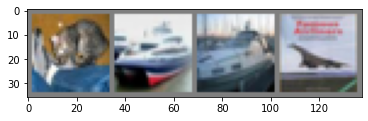

GroundTruth:    cat  ship  ship plane


In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
outputs = net(images)


In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [34]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 75 %
Accuracy of  bird : 39 %
Accuracy of   cat : 26 %
Accuracy of  deer : 43 %
Accuracy of   dog : 37 %
Accuracy of  frog : 67 %
Accuracy of horse : 64 %
Accuracy of  ship : 75 %
Accuracy of truck : 58 %


In [ ]:
## 

In [35]:
def describe(x): 
    print("Type: {}".format(x.type()))
    print("Shape: {}".format(x.shape))
    print("Values: {}".format(x))
    

In [36]:
describe(x)

Type: torch.FloatTensor
Shape: torch.Size([2, 2])
Values: tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [39]:
 spacy.load?

Signature: spacy.load(name, **overrides)
Docstring: <no docstring>
File:      ~/opt/anaconda3/envs/tabot/lib/python3.8/site-packages/spacy/__init__.py
Type:      function


In [42]:
!python -m spacy download en_core_web_sm

/Users/avani/opt/anaconda3/bin/python: No module named spacy


In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(u"Mary slapped the green witch.") 
for token in doc:
    print ('{} ­ {}'.format(token, token.pos_))
    

Mary ­ PROPN
slapped ­ VERB
the ­ DET
green ­ ADJ
witch ­ NOUN
. ­ PUNCT
